In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE

#imported ffrom the classification notebook
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GhanaChallenge/ghanachallenge/test.csv")

In [ ]:
trainweather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GhanaChallenge/ghanachallenge/train.csv")

In [ ]:
trainweather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,NaN,NaN,HEAVYRAIN,12


In [ ]:
trainweather.shape

(10928, 12)

In [ ]:
trainweather.dtypes

,0
ID,object
user_id,int64
confidence,float64
predicted_intensity,float64
community,object
district,object
prediction_time,object
indicator,object
indicator_description,object
time_observed,object


In [ ]:
trainweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10928 entries, 0 to 10927
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10928 non-null  object 
 1   user_id                10928 non-null  int64  
 2   confidence             10928 non-null  float64
 3   predicted_intensity    10928 non-null  float64
 4   community              10928 non-null  object 
 5   district               10928 non-null  object 
 6   prediction_time        10928 non-null  object 
 7   indicator              503 non-null    object 
 8   indicator_description  346 non-null    object 
 9   time_observed          72 non-null     object 
 10  Target                 10928 non-null  object 
 11  forecast_length        10928 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 1.0+ MB


In [ ]:
trainweather.isnull().sum()

,0
ID,0
user_id,0
confidence,0
predicted_intensity,0
community,0
district,0
prediction_time,0
indicator,10425
indicator_description,10582
time_observed,10856


In [ ]:
trainweather.describe()

,user_id,confidence,predicted_intensity,forecast_length
count,10928.000000,10928.000000,10928.000000,10928.000000
mean,40.534407,0.540474,0.026830,19.135432
std,22.970174,0.272068,0.132468,5.891856
min,7.000000,0.300000,0.000000,12.000000
25%,20.000000,0.300000,0.000000,12.000000
50%,43.000000,0.600000,0.000000,24.000000
75%,62.000000,0.600000,0.000000,24.000000
max,90.000000,1.000000,1.000000,24.000000


In [ ]:
print(trainweather.duplicated().sum())

0


EDA

In [ ]:
#the indicator column null values have to be filled
# Step 1: Define mapping between target and indicator
indicator_map = {
    'NORAIN': ['dew', 'fog', 'thunder', 'star', 'moon', 'heat','sun', 'wind','clouds'],
    'SMALLRAIN': ['wind', 'star', 'moon', 'sun','clouds'],
    'MEDIUMRAIN': ['heat', 'lightning', 'sun','clouds'],
    'HEAVYRAIN': ['heat', 'sun','clouds']
}

# Step 2: Fill null indicators based on the target column
def fill_indicator(row):
    if pd.isna(row['indicator']):
        options = indicator_map[row['Target']]
        return np.random.choice(options)
    return row['indicator']

trainweather['indicator'] = trainweather.apply(fill_indicator, axis=1)

# Step 3: Confirm all filled
print(trainweather['indicator'].isna().sum())  # should print 0

0


In [ ]:
trainweather.groupby(['Target', 'indicator']).size()




Target      indicator
HEAVYRAIN   clouds        108
            heat          104
            sun           103
MEDIUMRAIN  clouds        226
            heat          163
            lightning     188
            sun           184
NORAIN      clouds       1277
            dew          1013
            fog           993
            heat         1051
            lightning       1
            moon         1070
            star         1066
            sun          1101
            thunder       996
            wind         1044
SMALLRAIN   clouds         65
            moon           45
            star           41
            sun            50
            wind           39
dtype: int64

In [ ]:
# make sure it's in datetime format
trainweather["prediction_time"] = pd.to_datetime(trainweather["prediction_time"])

# extract date only
trainweather["prediction_date"] = trainweather["prediction_time"].dt.date
trainweather["prediction_year"] = trainweather["prediction_time"].dt.year
trainweather["prediction_month"] = trainweather["prediction_time"].dt.month
trainweather["prediction_day"] = trainweather["prediction_time"].dt.day

# extract time only
trainweather["prediction_hour"] = trainweather["prediction_time"].dt.hour   # just the hour
#trainweather["prediction_minute"] = trainweather["prediction_time"].dt.minute
#trainweather["prediction_second"] = trainweather["prediction_time"].dt.second

# OR if you want full time object (HH:MM:SS)
#trainweather["prediction_time_only"] = trainweather["prediction_time"].dt.time


In [ ]:
trainweather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length,prediction_date,prediction_year,prediction_month,prediction_day,prediction_hour
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,clouds,NaN,NaN,MEDIUMRAIN,12,2025-05-30,2025,5,30,11
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,heat,NaN,NaN,HEAVYRAIN,12,2025-05-30,2025,5,30,11
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,lightning,NaN,NaN,MEDIUMRAIN,12,2025-05-30,2025,5,30,11
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,heat,NaN,NaN,HEAVYRAIN,12,2025-05-30,2025,5,30,11
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,heat,NaN,NaN,HEAVYRAIN,12,2025-05-30,2025,5,30,11


In [ ]:
cat_cols = trainweather.select_dtypes('object').columns
num_cols = trainweather.select_dtypes(["int","float"]).columns

working with categorical columns

In [ ]:
# get the number of unique values in each column

for col in cat_cols:
    print(f"{col} have {trainweather[col].nunique()} labels")

ID have 10928 labels
community have 38 labels
district have 3 labels
indicator have 10 labels
indicator_description have 28 labels
time_observed have 8 labels
Target have 4 labels
prediction_date have 50 labels


In [ ]:
trainweather.drop(["indicator_description", "time_observed", "prediction_time", "prediction_date","prediction_year","community","district"], axis=1, inplace=True)
cat_cols = cat_cols.drop(["indicator_description","time_observed","prediction_time","prediction_date","community","district"])

KeyError: "['prediction_time'] not found in axis"

In [ ]:
trainweather.head()

,ID,user_id,confidence,predicted_intensity,indicator,Target,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_KwcTp_12,11,0.3,0.0,clouds,MEDIUMRAIN,12,5,30,11
1,ID_K9vWT_12,17,0.3,0.0,heat,HEAVYRAIN,12,5,30,11
2,ID_AIQg3_12,19,0.3,0.0,lightning,MEDIUMRAIN,12,5,30,11
3,ID_px4yf_12,23,0.3,0.0,heat,HEAVYRAIN,12,5,30,11
4,ID_QYYmK_12,23,0.3,0.0,heat,HEAVYRAIN,12,5,30,11


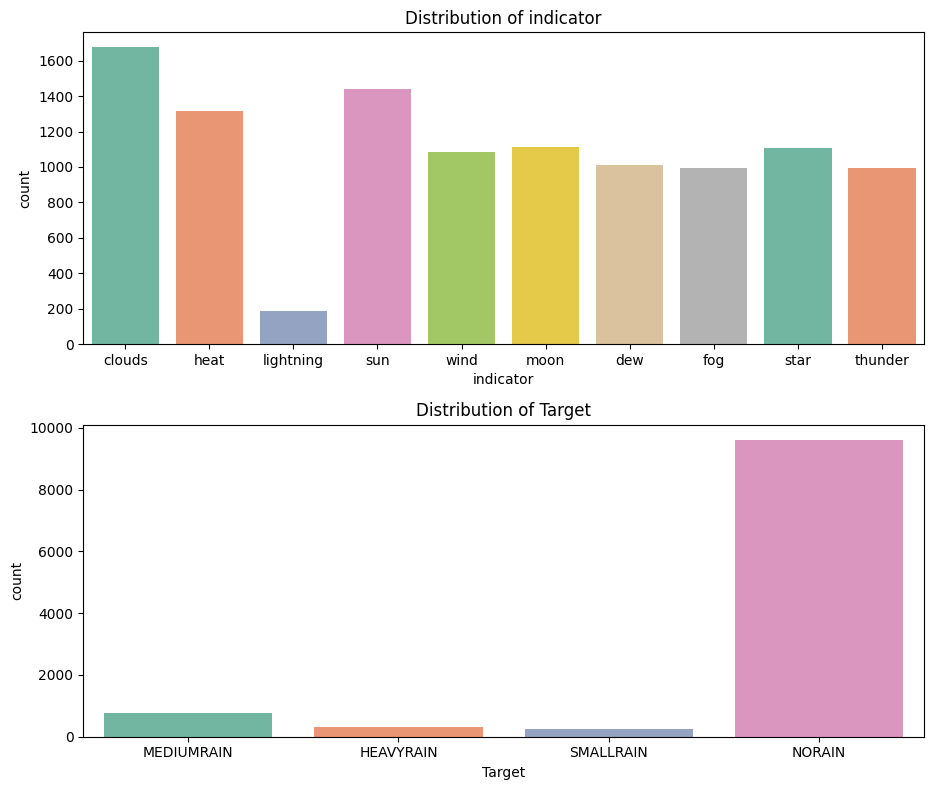

In [ ]:
cols = ["indicator" ,"Target"]
plt.figure(figsize=(18,8))

for i,col in enumerate(cols):  # 0 ,1
      # Countplot
    plt.subplot(2, 2,2*i+1)   # 1 ,3
    sns.countplot(x=col, data=trainweather, palette="Set2")
    plt.title(f"Distribution of {col}")



plt.tight_layout()
plt.show()

In [ ]:
# get the relationship between number of rain and indicators
pd.crosstab(trainweather["indicator"],trainweather["Target"] , normalize=True)*100

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
indicator,,,,
clouds,0.988287,2.068082,11.685578,0.594802
dew,0.000000,0.000000,9.269766,0.000000
fog,0.000000,0.000000,9.086750,0.000000
heat,0.951684,1.491581,9.617496,0.000000
lightning,0.000000,1.720351,0.009151,0.000000
moon,0.000000,0.000000,9.791362,0.411786
star,0.000000,0.000000,9.754758,0.375183
sun,0.942533,1.683748,10.075037,0.457540
thunder,0.000000,0.000000,9.114202,0.000000


Handling numerical columns

In [ ]:
print(f"The number of numerical columns {len(num_cols)}")

The number of numerical columns 8


In [ ]:
num_cols

Index(['user_id', 'confidence', 'predicted_intensity', 'forecast_length',
       'prediction_year', 'prediction_month', 'prediction_day',
       'prediction_hour'],
      dtype='object')

Encoding

In [ ]:
# Create a copy
train_encoded = trainweather.copy()

# Initialize encoder

le_target = LabelEncoder()
le_indicator = LabelEncoder()

trainweather['Target'] = le_target.fit_transform(trainweather['Target'].astype(str))
trainweather['indicator'] = le_indicator.fit_transform(trainweather['indicator'].astype(str))


Correlation matrix

Feature correlations with Target:
Target                 1.000000
confidence             0.239886
user_id                0.217224
prediction_day         0.119170
indicator              0.108818
predicted_intensity    0.007168
prediction_month      -0.041677
prediction_hour       -0.051811
forecast_length       -0.075225
dtype: float64


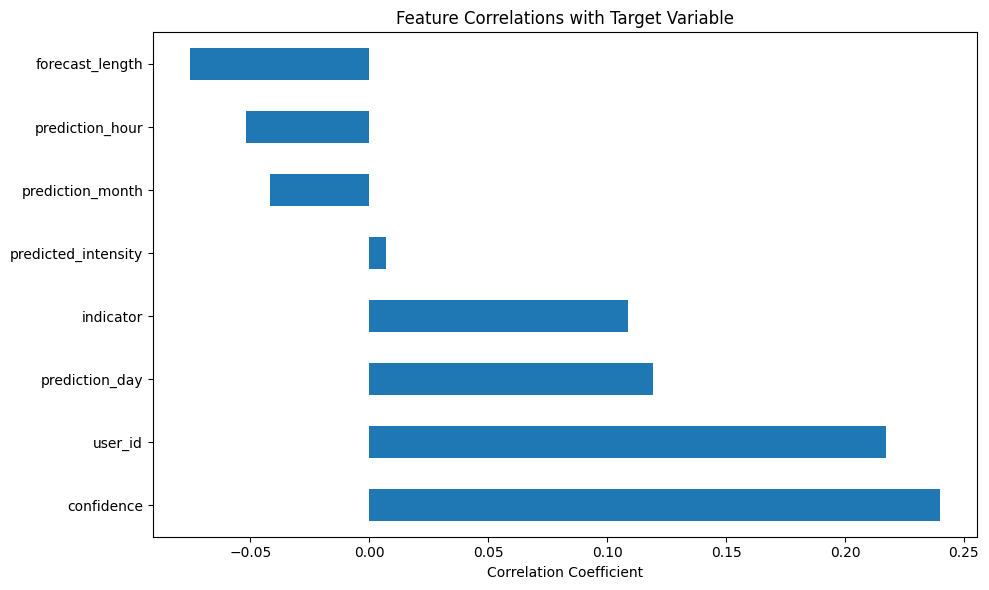

In [ ]:
#correlations with target
# Assuming your encoded target column is still called 'Target'
target_correlations = train_encoded.drop('ID', axis=1).corrwith(train_encoded['Target']).sort_values(ascending=False)

print("Feature correlations with Target:")
print(target_correlations)

# Plot the top correlations with target
plt.figure(figsize=(10, 6))
target_correlations.drop('Target').plot(kind='barh')  # Drop target itself
plt.title('Feature Correlations with Target Variable')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

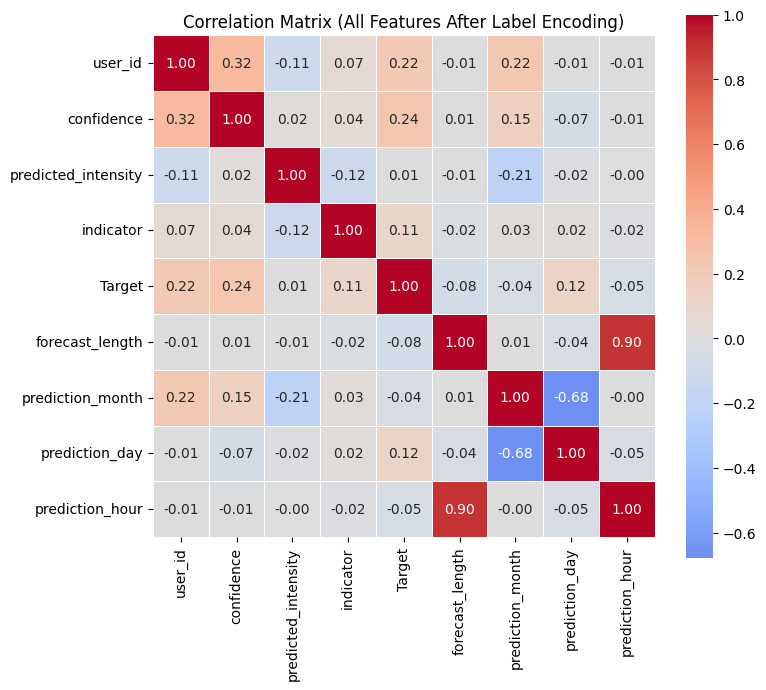

In [ ]:
#Drop ID column explicitly
correlation_matrix = train_encoded.drop('ID', axis=1).corr()

# Method 2: Select all columns except ID (more explicit)
correlation_matrix = train_encoded[[col for col in train_encoded.columns if col != 'ID']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Matrix (All Features After Label Encoding)')
plt.tight_layout()
plt.show()


Feature selection

Involves selecting features that will be used in the model

In [ ]:
X = train_encoded.drop(columns=["ID", "Target"], axis=1)
y = train_encoded["Target"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

print('\nClass Distribution in the train set:')
print(y_train.value_counts())
print('\nClass Distribution in the test set:')
print(y_test.value_counts())

Train Shape: (8742, 8)
Test Shape: (2186, 8)

Class Distribution in the train set:
Target
2    7689
1     609
0     252
3     192
Name: count, dtype: int64

Class Distribution in the test set:
Target
2    1923
1     152
0      63
3      48
Name: count, dtype: int64


In [ ]:
# Check class distribution
print("Class distribution:")
print(y.value_counts())

# If classes are very imbalanced, use SMOTE

Class distribution:
Target
2    9612
1     761
0     315
3     240
Name: count, dtype: int64


In [ ]:
#Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {pd.Series(y_train_resampled).value_counts()}")

Before SMOTE: Target
2    7689
1     609
0     252
3     192
Name: count, dtype: int64
After SMOTE: Target
2    7689
0    7689
1    7689
3    7689
Name: count, dtype: int64


In [ ]:
# Apply scaling on training data, then transform test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

BUILDING MODELS

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train_scaled, y_train_resampled)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0     0.9980    0.9970    0.9975      7689
           1     0.9970    0.9980    0.9975      7689
           2     1.0000    1.0000    1.0000      7689
           3     1.0000    1.0000    1.0000      7689

    accuracy                         0.9988     30756
   macro avg     0.9988    0.9988    0.9988     30756
weighted avg     0.9988    0.9988    0.9988     30756



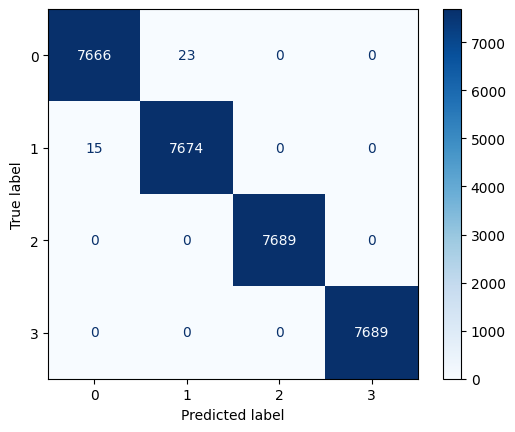

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# check on train

train_pred = dtc.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

              precision    recall  f1-score   support

           0     0.9385    0.9683    0.9531        63
           1     0.9667    0.9539    0.9603       152
           2     0.9953    0.9932    0.9943      1923
           3     0.8269    0.8958    0.8600        48

    accuracy                         0.9876      2186
   macro avg     0.9318    0.9528    0.9419      2186
weighted avg     0.9880    0.9876    0.9878      2186



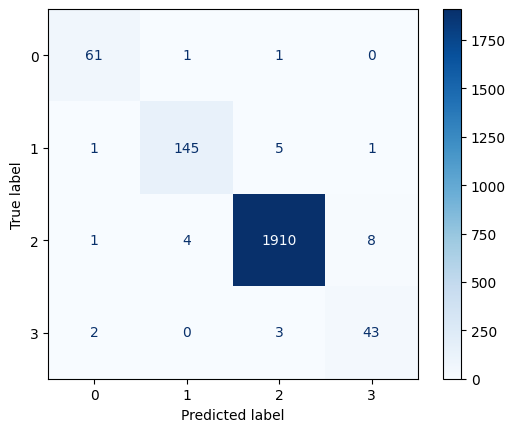

In [ ]:
# check on test

test_pred = dtc.predict(X_test_scaled)

print(classification_report(y_test , test_pred,digits=4))

conf= confusion_matrix(y_test,test_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train_resampled)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test_scaled)

              precision    recall  f1-score   support

           0     0.7067    0.9421    0.8076      7689
           1     0.7711    0.6300    0.6934      7689
           2     0.7053    0.5331    0.6072      7689
           3     0.7228    0.7907    0.7552      7689

    accuracy                         0.7240     30756
   macro avg     0.7265    0.7240    0.7159     30756
weighted avg     0.7265    0.7240    0.7159     30756



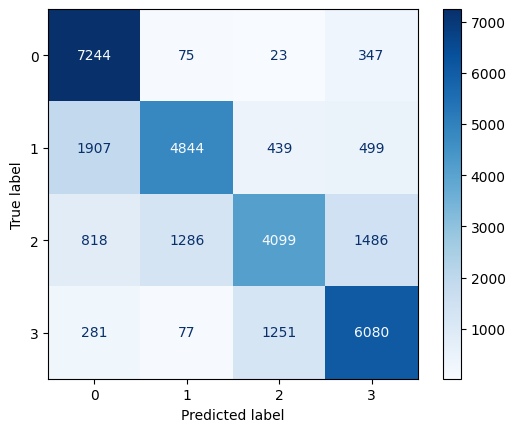

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# check on train

train_pred = logreg.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

              precision    recall  f1-score   support

           0     0.1869    0.9524    0.3125        63
           1     0.2269    0.5987    0.3291       152
           2     0.9808    0.5309    0.6889      1923
           3     0.0875    0.7708    0.1571        48

    accuracy                         0.5531      2186
   macro avg     0.3705    0.7132    0.3719      2186
weighted avg     0.8859    0.5531    0.6414      2186



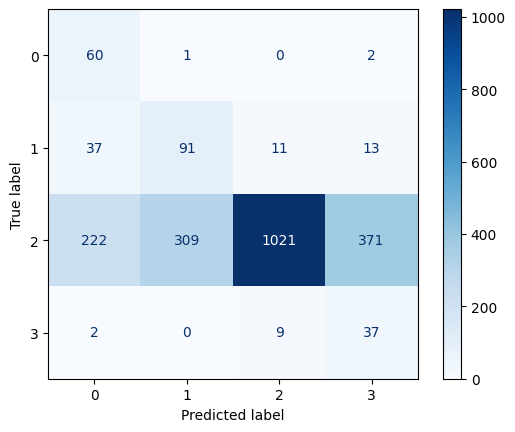

In [ ]:
# check on test

test_pred = logreg.predict(X_test_scaled)

print(classification_report(y_test , test_pred,digits=4))

conf= confusion_matrix(y_test,test_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train_scaled, y_train_resampled)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

              precision    recall  f1-score   support

           0     0.7785    0.9744    0.8655      7689
           1     0.9100    0.6482    0.7571      7689
           2     0.9068    0.7872    0.8428      7689
           3     0.8247    0.9632    0.8886      7689

    accuracy                         0.8433     30756
   macro avg     0.8550    0.8433    0.8385     30756
weighted avg     0.8550    0.8433    0.8385     30756



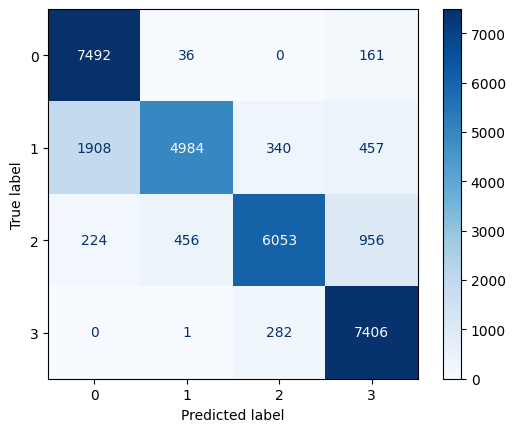

In [ ]:
# check on train

train_pred = rf.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

              precision    recall  f1-score   support

           0     0.3614    0.9524    0.5240        63
           1     0.4677    0.6184    0.5326       152
           2     0.9870    0.7868    0.8756      1923
           3     0.1469    0.8750    0.2515        48

    accuracy                         0.7818      2186
   macro avg     0.4907    0.8081    0.5459      2186
weighted avg     0.9144    0.7818    0.8279      2186



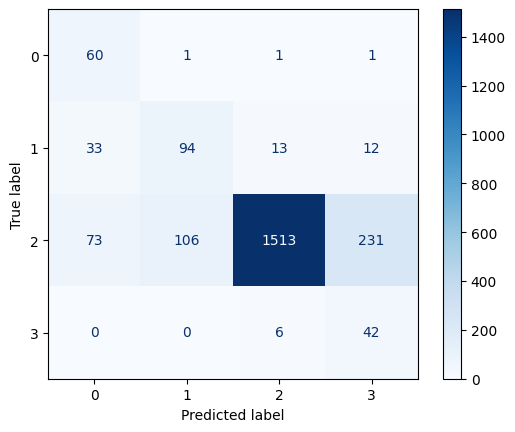

In [ ]:
test_pred = rf.predict(X_test_scaled)

print(classification_report(y_test , test_pred,digits=4))

conf= confusion_matrix(y_test,test_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

              precision    recall  f1-score   support

           0     0.7067    0.9421    0.8076      7689
           1     0.7711    0.6300    0.6934      7689
           2     0.7053    0.5331    0.6072      7689
           3     0.7228    0.7907    0.7552      7689

    accuracy                         0.7240     30756
   macro avg     0.7265    0.7240    0.7159     30756
weighted avg     0.7265    0.7240    0.7159     30756



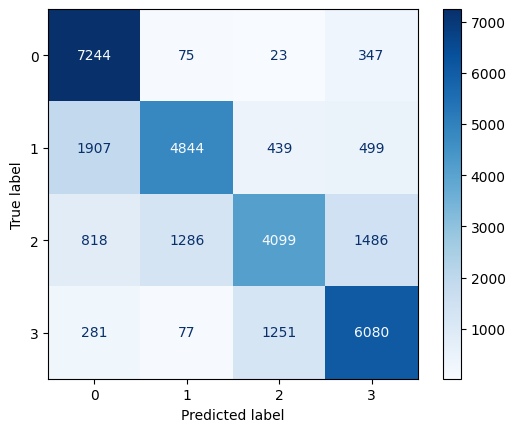

In [ ]:
# check on train

train_pred = logreg.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
kn = KNeighborsClassifier()
kn.fit(X_train_scaled, y_train_resampled)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0     0.7067    0.9421    0.8076      7689
           1     0.7711    0.6300    0.6934      7689
           2     0.7053    0.5331    0.6072      7689
           3     0.7228    0.7907    0.7552      7689

    accuracy                         0.7240     30756
   macro avg     0.7265    0.7240    0.7159     30756
weighted avg     0.7265    0.7240    0.7159     30756



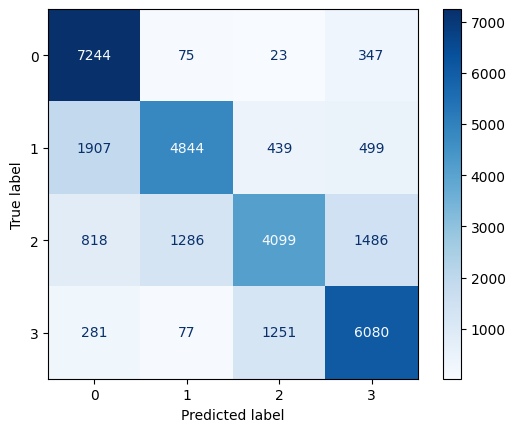

In [ ]:
# check on train

train_pred = logreg.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

Decision Tree model has been picked as the best model as accuracy is 0.99

Hyperparemeter tuning for the best model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define your base model
dtc = DecisionTreeClassifier(random_state=42)

# Define the parameter space
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': randint(3, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2']
}

# Create the random search object
random_search = RandomizedSearchCV(
    estimator=dtc,
    param_distributions=param_dist,
    n_iter=100,                # Number of parameter combinations to try
    scoring='f1_macro',
    cv=5,                      # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,                 # Use all available cores
    verbose=1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

# Use the best estimator for predictions
best_dt = random_search.best_estimator_

# Evaluate on test or validation data
y_pred = best_dt.predict(X_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'criterion': 'log_loss', 'max_depth': 45, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 9, 'splitter': 'best'}
Best F1 Score: 0.9479675133610856


Final Model Evaluation and Deployment

In [ ]:
#create a pipeline for scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', best_dt)
])

#Train the new model on the full training data
pipeline.fit(X_train, y_train)

#Final Evaluation
y_pred_final = pipeline.predict(X_test)
y_pred_prob_final = pipeline.predict_proba(X_test)[:,1]

print("Final Model Evaluation:")
print(f"Final Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
#print(f"Final ROC AUC: {roc_auc_score(y_test, y_pred_final):.4f}")
print("\n Final Classification Report")
print(classification_report(y_test,y_pred_final))

Final Model Evaluation:
Final Accuracy: 0.9867

 Final Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        63
           1       0.96      0.95      0.96       152
           2       0.99      0.99      0.99      1923
           3       0.91      0.85      0.88        48

    accuracy                           0.99      2186
   macro avg       0.95      0.94      0.95      2186
weighted avg       0.99      0.99      0.99      2186



SUBMISSION

In [ ]:
#weather is our test_df
weather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,forecast_length
0,ID_SbTdy_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:28,NaN,NaN,NaN,24
1,ID_SBKYz_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:29,NaN,NaN,NaN,24
2,ID_fAimg_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:30,NaN,NaN,NaN,24
3,ID_2wBqC_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:31,NaN,NaN,NaN,24
4,ID_NItox_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:32,NaN,NaN,NaN,24


In [ ]:
weatherid = weather["ID"]

In [ ]:
# make sure it's in datetime format
weather["prediction_time"] = pd.to_datetime(weather["prediction_time"])

# extract date only
weather["prediction_date"] = weather["prediction_time"].dt.date
weather["prediction_year"] = weather["prediction_time"].dt.year
weather["prediction_month"] = weather["prediction_time"].dt.month
weather["prediction_day"] = weather["prediction_time"].dt.day

# extract time only
weather["prediction_hour"] = weather["prediction_time"].dt.hour   # just the hour
#trainweather["prediction_minute"] = trainweather["prediction_time"].dt.minute
#trainweather["prediction_second"] = trainweather["prediction_time"].dt.second

# OR if you want full time object (HH:MM:SS)
#trainweather["prediction_time_only"] = trainweather["prediction_time"].dt.time

In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,forecast_length,prediction_date,prediction_year,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:28,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:29,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
2,ID_fAimg_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:30,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:31,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
4,ID_NItox_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:32,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19


In [ ]:
weather.drop(["indicator_description","time_observed","prediction_date","prediction_year","prediction_time","community","district"], axis=1, inplace=True)

In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,indicator,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,NaN,24,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,NaN,24,7,20,19
2,ID_fAimg_24,77,0.3,0.0,NaN,24,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,NaN,24,7,20,19
4,ID_NItox_24,77,0.3,0.0,NaN,24,7,20,19


In [ ]:
#the indicator column null values have to be filled


# Get existing indicator values from training data
indicators_list = weather['indicator'].dropna().unique()

# Fill missing indicators in test data randomly
weather['indicator'] = weather['indicator'].apply(
    lambda x: np.random.choice(indicators_list) if pd.isna(x) else x
)

In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,indicator,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,sun,24,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,star,24,7,20,19
2,ID_fAimg_24,77,0.3,0.0,heat,24,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,moon,24,7,20,19
4,ID_NItox_24,77,0.3,0.0,moon,24,7,20,19


In [ ]:
category_cols = weather.select_dtypes('object').columns

In [ ]:
category_cols

Index(['ID', 'indicator'], dtype='object')

In [ ]:
# Create a mapping dictionary from the fitted encoder
indicator_mapping = dict(zip(le_indicator.classes_, le_indicator.transform(le_indicator.classes_)))

# Safely map test indicators, assigning -1 to unseen values
weather['indicator'] = weather['indicator'].map(indicator_mapping).fillna(-1).astype(int)


In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,indicator,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,-1,24,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,-1,24,7,20,19
2,ID_fAimg_24,77,0.3,0.0,-1,24,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,-1,24,7,20,19
4,ID_NItox_24,77,0.3,0.0,-1,24,7,20,19


In [ ]:
# Select only the column for prediction
weather_test = weather[["indicator","user_id","confidence","predicted_intensity","forecast_length","prediction_month","prediction_day","prediction_hour"]]

In [ ]:
scaler = StandardScaler()
weather_test = pd.DataFrame(scaler.fit_transform(weather_test))

In [ ]:
predictions = best_dt.predict(weather_test)

decoded_predictions = le_target.inverse_transform(predictions)

output = pd.DataFrame({'ID': weatherid, 'Target': decoded_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
